# Agent Chat with Multimodal Models: LLaVA

This notebook uses **LLaVA** as an example for the multimodal feature. More information about LLaVA can be found in their [GitHub page](https://github.com/haotian-liu/LLaVA)


This notebook contains the following information and examples:

1. Setup LLaVA Model
    - Option 1: Use [API calls from `Replicate`](#replicate)
    - Option 2: Setup [LLaVA locally (requires GPU)](#local)
2. Application 1: [Image Chat](#app-1)
3. Application 2: [Figure Creator](#app-2)

### Before everything starts, install AutoGen with the `lmm` option
```bash
pip install "autogen-agentchat[lmm]~=0.2"
```

In [1]:
# We use this variable to control where you want to host LLaVA, locally or remotely?
# More details in the two setup options below.
import json
import os
import random
import time
from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union

import matplotlib.pyplot as plt
import requests
from PIL import Image
from termcolor import colored

import autogen
from autogen import Agent, AssistantAgent, ConversableAgent, UserProxyAgent
from autogen.agentchat.contrib.llava_agent import LLaVAAgent, llava_call

LLAVA_MODE = "remote"  # Either "local" or "remote"
assert LLAVA_MODE in ["local", "remote"]

<a id="replicate"></a>
## (Option 1, preferred) Use API Calls from Replicate [Remote]
We can also use [Replicate](https://replicate.com/yorickvp/llava-13b/api) to use LLaVA directly, which will host the model for you.

1. Run `pip install replicate` to install the package
2. You need to get an API key from Replicate from your [account setting page](https://replicate.com/account/api-tokens)
3. Next, copy your API token and authenticate by setting it as an environment variable:
    `export REPLICATE_API_TOKEN=<paste-your-token-here>` 
4. You need to enter your credit card information for Replicate 🥲
    

In [3]:
# pip install replicate
# import os
## alternatively, you can put your API key here for the environment variable.
# os.environ["REPLICATE_API_TOKEN"] = "r8_xyz your api key goes here~"

In [4]:
if LLAVA_MODE == "remote":
    import replicate

    llava_config_list = [
        {
            "model": "whatever, will be ignored for remote",  # The model name doesn't matter here right now.
            "api_key": "None",  # Note that you have to setup the API key with os.environ["REPLICATE_API_TOKEN"]
            "base_url": "yorickvp/llava-13b:2facb4a474a0462c15041b78b1ad70952ea46b5ec6ad29583c0b29dbd4249591",
        }
    ]

<a id="local"></a>
## [Option 2] Setup LLaVA Locally


## Install the LLaVA library

Please follow the LLaVA GitHub [page](https://github.com/haotian-liu/LLaVA/) to install LLaVA.


#### Download the package
```bash
git clone https://github.com/haotian-liu/LLaVA.git
cd LLaVA
```

#### Install the inference package
```bash
conda create -n llava python=3.10 -y
conda activate llava
pip install --upgrade pip  # enable PEP 660 support
pip install -e .
```



Some helpful packages and dependencies:
```bash
conda install -c nvidia cuda-toolkit
```


### Launch

In one terminal, start the controller first:
```bash
python -m llava.serve.controller --host 0.0.0.0 --port 10000
```


Then, in another terminal, start the worker, which will load the model to the GPU:
```bash
python -m llava.serve.model_worker --host 0.0.0.0 --controller http://localhost:10000 --port 40000 --worker http://localhost:40000 --model-path liuhaotian/llava-v1.5-13b
``

In [5]:
# Run this code block only if you want to run LlaVA locally
if LLAVA_MODE == "local":
    llava_config_list = [
        {
            "model": "llava-v1.5-13b",
            "api_key": "None",
            "base_url": "http://0.0.0.0:10000",
        }
    ]

# Multimodal Functions

We cal test the `llava_call` function with the following AutoGen image.
![](https://raw.githubusercontent.com/microsoft/autogen/main/website/static/img/autogen_agentchat.png)


In [7]:
rst = llava_call(
    "Describe this AutoGen framework <img https://raw.githubusercontent.com/microsoft/autogen/main/website/static/img/autogen_agentchat.png> with bullet points.",
    llm_config={"config_list": llava_config_list, "temperature": 0},
)

print(rst)

The AutoGen framework is a tool for creating and managing conversational agents. It allows for the creation of multiple-agent conversations, enabling complex interactions between different agents. The framework is designed to be flexible and scalable, allowing for the addition of new agents and conversations as needed.

The framework consists of three main components:

1. Agents: These are the individual conversational entities that can be created and managed within the framework. Each agent has its own unique set of conversational capabilities and can engage in conversations with other agents.

2. Conversations: These are the interactions between agents, which can be managed and directed by the framework. Conversations can be structured and organized to facilitate efficient communication between agents.

3. Flexibility: The framework is designed to be flexible, allowing for the addition of new agents and conversations as needed. This flexibility enables the framework to adapt to chang

<a id="app-1"></a>
## Application 1: Image Chat

In this section, we present a straightforward dual-agent architecture to enable user to chat with a multimodal agent.


First, we show this image and ask a question.
![](https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0)

Within the user proxy agent, we can decide to activate the human input mode or not (for here, we use human_input_mode="NEVER" for conciseness). This allows you to interact with LLaVA in a multi-round dialogue, enabling you to provide feedback as the conversation unfolds.

In [9]:
image_agent = LLaVAAgent(
    name="image-explainer",
    max_consecutive_auto_reply=10,
    llm_config={"config_list": llava_config_list, "temperature": 0.5, "max_new_tokens": 1000},
)

user_proxy = autogen.UserProxyAgent(
    name="User_proxy",
    system_message="A human admin.",
    code_execution_config={
        "last_n_messages": 3,
        "work_dir": "groupchat",
        "use_docker": False,
    },  # Please set use_docker=True if docker is available to run the generated code. Using docker is safer than running the generated code directly.
    human_input_mode="NEVER",  # Try between ALWAYS or NEVER
    max_consecutive_auto_reply=0,
)

# Ask the question with an image
user_proxy.initiate_chat(
    image_agent,
    message="""What's the breed of this dog?
<img https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0>.""",
)

User_proxy (to image-explainer):

What's the breed of this dog? 
<image>.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
You are an AI agent and you can view images.
###Human: What's the breed of this dog? 
<image>.

###Assistant: 
image-explainer (to User_proxy):

The breed of the dog in the image is a poodle.

--------------------------------------------------------------------------------


Now, input another image, and ask a followup question.

![](https://th.bing.com/th/id/OIP.29Mi2kJmcHHyQVGe_0NG7QHaEo?pid=ImgDet&rs=1)

In [10]:
# Ask the question with an image
user_proxy.send(
    message="""What is this breed?
<img https://th.bing.com/th/id/OIP.29Mi2kJmcHHyQVGe_0NG7QHaEo?pid=ImgDet&rs=1>

Among the breeds, which one barks less?""",
    recipient=image_agent,
)

User_proxy (to image-explainer):

What is this breed? 
<image>

Among the breeds, which one barks less?

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
You are an AI agent and you can view images.
###Human: What's the breed of this dog? 
<image>.
###Assistant: The breed of the dog in the image is a poodle.
###Human: What is this breed? 
<image>

Among the breeds, which one barks less?

###Assistant: 
image-explainer (to User_proxy):

Among the breeds, poodles tend to bark less compared to other breeds. However, it is important to note that individual dogs may have different temperaments and barking habits, regardless of their breed.

--------------------------------------------------------------------------------


<a id="app-2"></a>
## Application 2: Figure Creator

Here, we define a `FigureCreator` agent, which contains three child agents: commander, coder, and critics.

- Commander: interacts with users, runs code, and coordinates the flow between the coder and critics.
- Coder: writes code for visualization.
- Critics: LLaVA-based agent that provides comments and feedback on the generated image.

In [11]:
class FigureCreator(AssistantAgent):
    def __init__(self, n_iters=2, **kwargs):
        """
        Initializes a FigureCreator instance.

        This agent facilitates the creation of visualizations through a collaborative effort among its child agents: commander, coder, and critics.

        Parameters:
            - n_iters (int, optional): The number of "improvement" iterations to run. Defaults to 2.
            - **kwargs: keyword arguments for the parent AssistantAgent.
        """
        super().__init__(**kwargs)
        self.register_reply([Agent, None], reply_func=FigureCreator._reply_user, position=0)
        self._n_iters = n_iters

    def _reply_user(self, messages=None, sender=None, config=None):
        if all((messages is None, sender is None)):
            error_msg = f"Either {messages=} or {sender=} must be provided."
            logger.error(error_msg)  # noqa: F821
            raise AssertionError(error_msg)

        if messages is None:
            messages = self._oai_messages[sender]

        user_question = messages[-1]["content"]

        ### Define the agents
        commander = AssistantAgent(
            name="Commander",
            human_input_mode="NEVER",
            max_consecutive_auto_reply=10,
            system_message="Help me run the code, and tell other agents it is in the <img result.jpg> file location.",
            is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE"),
            code_execution_config={
                "last_n_messages": 3,
                "work_dir": ".",
                "use_docker": False,
            },  # Please set use_docker=True if docker is available to run the generated code. Using docker is safer than running the generated code directly.
            llm_config=self.llm_config,
        )

        critics = LLaVAAgent(
            name="Critics",
            system_message="""Criticize the input figure. How to replot the figure so it will be better? Find bugs and issues for the figure.
            Pay attention to the color, format, and presentation. Keep in mind of the reader-friendliness.
            If you think the figures is good enough, then simply say NO_ISSUES""",
            llm_config={"config_list": llava_config_list},
            human_input_mode="NEVER",
            max_consecutive_auto_reply=1,
            #     use_docker=False,
        )

        coder = AssistantAgent(
            name="Coder",
            llm_config=self.llm_config,
        )

        coder.update_system_message(
            coder.system_message
            + "ALWAYS save the figure in `result.jpg` file. Tell other agents it is in the <img result.jpg> file location."
        )

        # Data flow begins
        commander.initiate_chat(coder, message=user_question)
        img = Image.open("result.jpg")
        plt.imshow(img)
        plt.axis("off")  # Hide the axes
        plt.show()

        for i in range(self._n_iters):
            commander.send(message="Improve <img result.jpg>", recipient=critics, request_reply=True)

            feedback = commander._oai_messages[critics][-1]["content"]
            if feedback.find("NO_ISSUES") >= 0:
                break
            commander.send(
                message="Here is the feedback to your figure. Please improve! Save the result to `result.jpg`\n"
                + feedback,
                recipient=coder,
                request_reply=True,
            )
            img = Image.open("result.jpg")
            plt.imshow(img)
            plt.axis("off")  # Hide the axes
            plt.show()

        return True, "result.jpg"

User (to Figure Creator~):


Plot a figure by using the data from:
https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv

I want to show both temperature high and low.


--------------------------------------------------------------------------------
Commander (to Coder):


Plot a figure by using the data from:
https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv

I want to show both temperature high and low.


--------------------------------------------------------------------------------
Coder (to Commander):

First, we will download the CSV file, then we will parse it using pandas, a popular data analysis library in Python. After that, we will plot the data using matplotlib.

This is how we could do this:

```python
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load the Data
url = "https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv"
data = pd.read_csv(url)

# Step 2: Parse the date to da

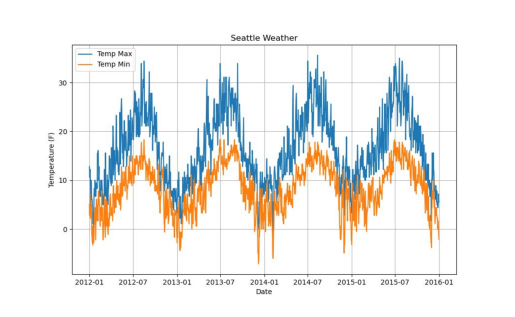

Commander (to Critics):

Improve <image>

--------------------------------------------------------------------------------
Criticize the input figure. How to replot the figure so it will be better? Find bugs and issues for the figure. 
            Pay attention to the color, format, and presentation. Keep in mind of the reader-friendliness.
            If you think the figures is good enough, then simply say NO_ISSUES
###Human: Improve <image>

###Assistant: 
Critics (to Commander):

The input figure shows a graph of Seattle weather, with a blue line representing the temperature and an orange line representing the humidity. The graph is displayed on a white background, with the title "Seattle Weather" at the top.

There are a few issues with the figure that could be improved:

1. The color scheme for the temperature and humidity lines is not clear. The blue line represents the temperature, but it is not immediately clear to the viewer. A more distinct color or labeling could help clari

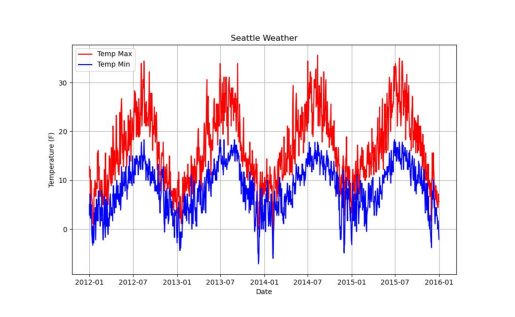

Commander (to Critics):

Improve <image>

--------------------------------------------------------------------------------
Commander (to Coder):

Here is the feedback to your figure. Please improve! Save the result to `result.jpg`
Improve <img result.jpg>

--------------------------------------------------------------------------------
Coder (to Commander):

I apologize for the misunderstanding, but without more specific feedback about the figure, it's difficult to understand what improvements are needed. As of now, the figure includes distinct colors for max and min temperatures, clear labeling of lines, and proper axis labels.

However, if you want to improve visual clarity, you can try:

- Changing the line style (making one of them dotted, for instance).
- Adding a title to the legend for better clarification.
- Changing the figure size for a improved view.

Here is the modified code:

```python
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load the Data
url = "htt

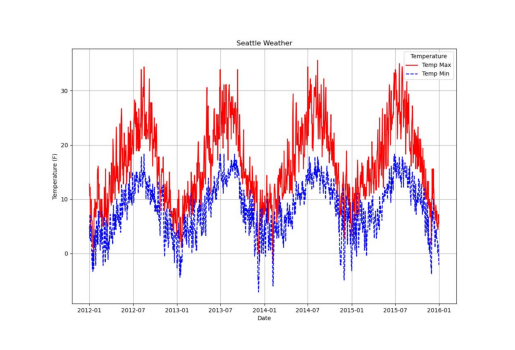

Figure Creator~ (to User):

result.jpg

--------------------------------------------------------------------------------


In [12]:
config_list_gpt4 = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4", "gpt-4-0314", "gpt4", "gpt-4-32k", "gpt-4-32k-0314", "gpt-4-32k-v0314"],
    },
)

gpt4_llm_config = {"config_list": config_list_gpt4, "cache_seed": 42}

# config_list_gpt35 = autogen.config_list_from_json(
#     "OAI_CONFIG_LIST",
#     filter_dict={
#         "model": ["gpt-35-turbo", "gpt-3.5-turbo"],
#     },
# )

# gpt35_llm_config = {"config_list": config_list_gpt35, "cache_seed": 42}


creator = FigureCreator(name="Figure Creator~", llm_config=gpt4_llm_config)

user_proxy = autogen.UserProxyAgent(
    name="User", human_input_mode="NEVER", max_consecutive_auto_reply=0, code_execution_config={"use_docker": False}
)  # Please set use_docker=True if docker is available to run the generated code. Using docker is safer than running the generated code directly.

user_proxy.initiate_chat(
    creator,
    message="""
Plot a figure by using the data from:
https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv

I want to show both temperature high and low.
""",
)

In [13]:
if os.path.exists("result.jpg"):
    os.remove("result.jpg")  # clean up